# Colorización de Imágenes con GANs - Arquitectura del Generador
**Grupo 6 - Proyecto Final**

Implementación de U-Net Generator para colorización automática de imágenes.

In [ ]:
# Instalación de dependencias (si es necesario)
# !pip install torch torchvision pillow scikit-image matplotlib numpy

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import color
from pathlib import Path
import time
import json
from typing import Tuple, Dict, List

## Bloques de la arquitectura
Componentes modulares del U-Net

In [7]:
class DownBlock(nn.Module):
    """Bloque de downsampling (encoder) con Conv + BatchNorm + LeakyReLU"""
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super(DownBlock, self).__init__()
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4,
                           stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [8]:
class UpBlock(nn.Module):
    """Bloque de upsampling (decoder) con ConvTranspose + BatchNorm + ReLU"""
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(UpBlock, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels,
                              kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        # Concatenar skip connection
        x = torch.cat([x, skip_input], dim=1)
        return x

In [9]:
# Test de bloques
print("Bloques creados correctamente")
test_down = DownBlock(3, 64)
test_up = UpBlock(64, 32)
print(f"   DownBlock parámetros: {sum(p.numel() for p in test_down.parameters()):,}")
print(f"   UpBlock parámetros: {sum(p.numel() for p in test_up.parameters()):,}")

Bloques creados correctamente
   DownBlock parámetros: 3,200
   UpBlock parámetros: 32,832


## Generador U-Net Completo
Arquitectura de 7 niveles con skip connections

In [10]:
class UNetGenerator(nn.Module):
    """
    Generador U-Net para colorización de imágenes
    Input: Imagen en escala de grises (1 canal)
    Output: Imagen con canales ab del espacio LAB (2 canales)
    """
    def __init__(self, input_channels=1, output_channels=2, features=64):
        super(UNetGenerator, self).__init__()

        # ENCODER (Downsampling path)
        self.down1 = DownBlock(input_channels, features, normalize=False)  # 64
        self.down2 = DownBlock(features, features * 2)                      # 128
        self.down3 = DownBlock(features * 2, features * 4)                  # 256
        self.down4 = DownBlock(features * 4, features * 8)                  # 512
        self.down5 = DownBlock(features * 8, features * 8)                  # 512
        self.down6 = DownBlock(features * 8, features * 8)                  # 512
        self.down7 = DownBlock(features * 8, features * 8)                  # 512

        # BOTTLENECK
        self.bottleneck = DownBlock(features * 8, features * 8, normalize=False)  # 512

        # DECODER (Upsampling path con skip connections)
        self.up1 = UpBlock(features * 8, features * 8, dropout=0.5)
        self.up2 = UpBlock(features * 16, features * 8, dropout=0.5)  # *16 por concatenación
        self.up3 = UpBlock(features * 16, features * 8, dropout=0.5)
        self.up4 = UpBlock(features * 16, features * 8)
        self.up5 = UpBlock(features * 16, features * 4)
        self.up6 = UpBlock(features * 8, features * 2)
        self.up7 = UpBlock(features * 4, features)

        # Capa final para generar los 2 canales de color (a, b)
        self.final = nn.Sequential(
            nn.ConvTranspose2d(features * 2, output_channels, kernel_size=4,
                              stride=2, padding=1),
            nn.Tanh()  # Salida en rango [-1, 1] para canales a y b
        )

    def forward(self, x):
        # ENCODER con guardado de skip connections
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)

        # BOTTLENECK
        bottleneck = self.bottleneck(d7)

        # DECODER con skip connections
        u1 = self.up1(bottleneck, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        # Salida final
        output = self.final(u7)

        return output

In [12]:
# Crear instancia del generador
generator = UNetGenerator(input_channels=1, output_channels=2, features=64)

print("Generador U-Net creado")
print(f"   Total parámetros: {sum(p.numel() for p in generator.parameters()):,}")
print(f"   Parámetros entrenables: {sum(p.numel() for p in generator.parameters() if p.requires_grad):,}")
print(f"   Memoria aproximada: {sum(p.numel() * p.element_size() for p in generator.parameters()) / 1e6:.2f} MB")

Generador U-Net creado
   Total parámetros: 54,409,858
   Parámetros entrenables: 54,409,858
   Memoria aproximada: 217.64 MB


## Visualizar la arquitectura

In [17]:
def visualize_architecture(generator, input_size=(1, 256, 256)):
    """Visualiza el flujo de dimensiones a través de la red"""
    print("FLUJO DE DIMENSIONES EN U-NET")

    # Crear tensor de prueba
    x = torch.randn(1, *input_size)

    # Forward pass con tracking de dimensiones
    print(f"Input (Grayscale L):     {tuple(x.shape)}")
    print("\nENCODER (Downsampling)")

    with torch.no_grad():
        d1 = generator.down1(x)
        print(f"  Down1:                 {tuple(d1.shape)}")
        d2 = generator.down2(d1)
        print(f"  Down2:                 {tuple(d2.shape)}")
        d3 = generator.down3(d2)
        print(f"  Down3:                 {tuple(d3.shape)}")
        d4 = generator.down4(d3)
        print(f"  Down4:                 {tuple(d4.shape)}")
        d5 = generator.down5(d4)
        print(f"  Down5:                 {tuple(d5.shape)}")
        d6 = generator.down6(d5)
        print(f"  Down6:                 {tuple(d6.shape)}")
        d7 = generator.down7(d6)
        print(f"  Down7:                 {tuple(d7.shape)}")

        print("\nBOTTLENECK")
        bottleneck = generator.bottleneck(d7)
        print(f"  Bottleneck:            {tuple(bottleneck.shape)}")

        print("\nDECODER (Upsampling + Skip Connections)")
        u1 = generator.up1(bottleneck, d7)
        print(f"  Up1 (+ skip d7):       {tuple(u1.shape)}")
        u2 = generator.up2(u1, d6)
        print(f"  Up2 (+ skip d6):       {tuple(u2.shape)}")
        u3 = generator.up3(u2, d5)
        print(f"  Up3 (+ skip d5):       {tuple(u3.shape)}")
        u4 = generator.up4(u3, d4)
        print(f"  Up4 (+ skip d4):       {tuple(u4.shape)}")
        u5 = generator.up5(u4, d3)
        print(f"  Up5 (+ skip d3):       {tuple(u5.shape)}")
        u6 = generator.up6(u5, d2)
        print(f"  Up6 (+ skip d2):       {tuple(u6.shape)}")
        u7 = generator.up7(u6, d1)
        print(f"  Up7 (+ skip d1):       {tuple(u7.shape)}")

        output = generator.final(u7)
        print(f"\nOutput (Color a,b):      {tuple(output.shape)}")

visualize_architecture(generator)

FLUJO DE DIMENSIONES EN U-NET
Input (Grayscale L):     (1, 1, 256, 256)

ENCODER (Downsampling)
  Down1:                 (1, 64, 128, 128)
  Down2:                 (1, 128, 64, 64)
  Down3:                 (1, 256, 32, 32)
  Down4:                 (1, 512, 16, 16)
  Down5:                 (1, 512, 8, 8)
  Down6:                 (1, 512, 4, 4)
  Down7:                 (1, 512, 2, 2)

BOTTLENECK
  Bottleneck:            (1, 512, 1, 1)

DECODER (Upsampling + Skip Connections)
  Up1 (+ skip d7):       (1, 1024, 2, 2)
  Up2 (+ skip d6):       (1, 1024, 4, 4)
  Up3 (+ skip d5):       (1, 1024, 8, 8)
  Up4 (+ skip d4):       (1, 1024, 16, 16)
  Up5 (+ skip d3):       (1, 512, 32, 32)
  Up6 (+ skip d2):       (1, 256, 64, 64)
  Up7 (+ skip d1):       (1, 128, 128, 128)

Output (Color a,b):      (1, 2, 256, 256)


## Función de Pérdida del Generador
Combinación de pérdida adversarial (GAN) y L1

In [18]:
class GeneratorLoss(nn.Module):
    """
    Función de pérdida combinada para el generador
    Incluye pérdida adversarial (GAN) y pérdida de reconstrucción (L1)
    L_total = L_adversarial + λ * L_L1
    """
    def __init__(self, lambda_l1=100):
        super(GeneratorLoss, self).__init__()
        self.lambda_l1 = lambda_l1
        self.l1_loss = nn.L1Loss()
        self.adversarial_loss = nn.BCEWithLogitsLoss()

    def forward(self, fake_output, real_ab, discriminator_pred):
        """
        Args:
            fake_output: Imagen generada (canales ab)
            real_ab: Imagen real (canales ab)
            discriminator_pred: Predicción del discriminador sobre la imagen falsa
        Returns:
            total_loss, adv_loss, l1_loss
        """
        # Pérdida adversarial: queremos que el discriminador clasifique como real
        real_labels = torch.ones_like(discriminator_pred)
        adv_loss = self.adversarial_loss(discriminator_pred, real_labels)

        # Pérdida L1: similitud pixel a pixel con la imagen real
        l1_loss = self.l1_loss(fake_output, real_ab)

        # Pérdida total
        total_loss = adv_loss + self.lambda_l1 * l1_loss

        return total_loss, adv_loss, l1_loss

In [19]:
# Instancia función de pérdida
criterion = GeneratorLoss(lambda_l1=100)

print("Función de pérdida configurada")
print(f"   Lambda L1: {criterion.lambda_l1}")
print(f"   Componentes: Adversarial Loss + {criterion.lambda_l1} × L1 Loss")

Función de pérdida configurada
   Lambda L1: 100
   Componentes: Adversarial Loss + 100 × L1 Loss


## pesos

In [20]:
def init_weights(model):
    """Inicializa pesos siguiendo la estrategia DCGAN"""
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0.0)

    model.apply(init_func)
    print("Pesos inicializados (Normal μ=0, σ=0.02)")

# Inicializar pesos del generador
init_weights(generator)

Pesos inicializados (Normal μ=0, σ=0.02)


## optimización

In [22]:
# Hiperparámetros
LEARNING_RATE = 2e-4
BETA1 = 0.5  # Momentum reducido para GANs
BETA2 = 0.999

# Optimizador Adam
optimizer_G = optim.Adam(
    generator.parameters(),
    lr=LEARNING_RATE,
    betas=(BETA1, BETA2)
)

# Learning rate scheduler
scheduler_G = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_G,
    mode='min',
    factor=0.5,
    patience=5
)

print("Optimizador configurado")
print(f"   Tipo: Adam")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Betas: ({BETA1}, {BETA2})")
print(f"   Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)")

Optimizador configurado
   Tipo: Adam
   Learning Rate: 0.0002
   Betas: (0.5, 0.999)
   Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)


## Prueba

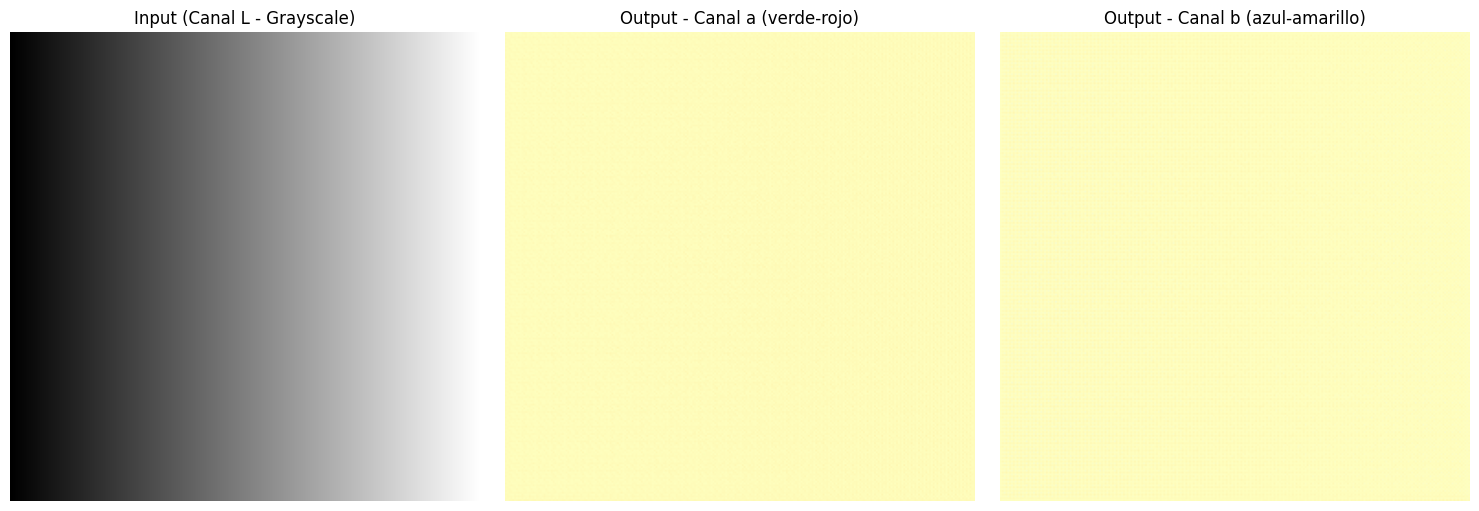

Test completado
   Input shape: torch.Size([1, 1, 256, 256])
   Output shape: torch.Size([1, 2, 256, 256])
   Output range: [-0.063, 0.059]


In [23]:
def test_generator():
    """Prueba el generador con datos sintéticos"""
    generator.eval()

    # Crear imagen de prueba (gradiente)
    test_L = torch.linspace(-1, 1, 256).unsqueeze(0).repeat(256, 1).unsqueeze(0).unsqueeze(0)

    with torch.no_grad():
        fake_ab = generator(test_L)

    # Visualizar
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Grayscale input
    axes[0].imshow(test_L[0, 0].cpu(), cmap='gray')
    axes[0].set_title('Input (Canal L - Grayscale)')
    axes[0].axis('off')

    # Canal a generado
    axes[1].imshow(fake_ab[0, 0].cpu(), cmap='RdYlGn', vmin=-1, vmax=1)
    axes[1].set_title('Output - Canal a (verde-rojo)')
    axes[1].axis('off')

    # Canal b generado
    axes[2].imshow(fake_ab[0, 1].cpu(), cmap='RdYlBu_r', vmin=-1, vmax=1)
    axes[2].set_title('Output - Canal b (azul-amarillo)')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Test completado")
    print(f"   Input shape: {test_L.shape}")
    print(f"   Output shape: {fake_ab.shape}")
    print(f"   Output range: [{fake_ab.min():.3f}, {fake_ab.max():.3f}]")

test_generator()

##